# Homework

0. Load spam or twitter dataset, vectorize, split into train/test
1. Train SVM
2. Train Naive Bayes Classifier
3. Compare the quality of two classifiers
4. (OPTIONAL) Run imbalanced learn with SVM instead of LogReg. Plot decision boundaries, compare. Play with algorithms parameters if necessary. You may try some other algorithm from imbalanced-learn.


## Task 0. Dataset Loading, Vectorizing and Splitting

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('Tweets.csv')

In [3]:
data

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


In [4]:
# Cleaning up the text by removing punctuation and special characters
import spacy
import re
import emoji
import string
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_sm')

def clean_text_spacy(text):
    # Removing punctuation and special characters
    text = text.translate(str.maketrans('', '', "“”" + string.punctuation.replace('@', '')))
    
    # Clean up stopwords, emojis, links and tags + lemmatization
    text = emoji.replace_emoji(text, replace='<EMOJI>')
    text = re.sub(r'http[^\s]+', '<LINK>', text)
    text = re.sub(r'@\w+', '<TAG>', text)

    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if token.text.lower() not in STOP_WORDS]
    text = ' '.join(tokens).strip()
    text = re.sub(r'(?<=<) (?=\w+)|(?<=\w) (?=>)', '', text)
    text = re.sub(r'\s{2,}', ' ', text)
    return text

C:\Users\email\AppData\Local\Programs\Python\Python39\lib\site-packages\spacy\util.py:877: UserWarning: [W095] Model 'en_core_web_sm' (3.4.1) was trained with spaCy v3.4 and may not be 100% compatible with the current version (3.5.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [5]:
data['text_clean'] = data['text'].apply(clean_text_spacy)

In [6]:
data['text_clean'][:20]

0                                       <tag> <tag> say
1         <tag> plus ve add commercial experience tacky
2                        <tag> not today mean need trip
3     <tag> aggressive blast obnoxious entertainment...
4                                   <tag> big bad thing
5     <tag> seriously pay 30 flight seat not playing...
6       <tag> yes nearly time fly vx ear worm will away
7     <tag> miss prime opportunity men hats parody <...
8                                       <tag> didnt … d
9                  <tag> amazing arrive hour early good
10    <tag> know suicide second lead cause death tee...
11    <tag> lt3 pretty graphic well minimal iconogra...
12    <tag> great deal think 2nd trip <tag> amp not ...
13    <tag> <tag> m fly fabulous seductive sky u str...
14                                          <tag> thank
15                            <tag> sfopdx schedule mia
16    <tag> excited cross country flight lax mco ve ...
17    <tag> fly nyc sfo week not fully sit seat 

Vectorizing

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import numpy as np
from nltk.corpus import stopwords

In [8]:
vectorizer = TfidfVectorizer(max_features=1000, min_df=7, max_df=0.8, stop_words=stopwords.words('english'), ngram_range=(1,2))

In [9]:
texts = data['text_clean']

In [10]:
labels = data['airline_sentiment']

In [11]:
labels = LabelEncoder().fit_transform(labels)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, shuffle=True, random_state=42)

In [13]:
X_train_vect = vectorizer.fit_transform(X_train).toarray()

In [14]:
X_test_vect = vectorizer.transform(X_test).toarray()

## Task 1. SVM Training

In [15]:
from sklearn import svm

In [16]:
svm_classifier = svm.SVC(kernel='linear', random_state=42)

In [17]:
#Train the model using the training sets
svm_classifier.fit(X_train_vect, y_train)

SVC(kernel='linear', random_state=42)

In [18]:
#Predict the response for test dataset
y_pred = svm_classifier.predict(X_test_vect)

In [19]:
# Evaluating the model using accuracy, F1-score, recall, and precision
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("F1-score:", f1)
print("Recall:", recall)
print("Precision:", precision)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.7790300546448088
F1-score: 0.6937369479453653
Recall: 0.6720604690198592
Precision: 0.7263837979186717
Confusion Matrix:
 [[1716  115   58]
 [ 264  271   45]
 [ 113   52  294]]


------------------

Experiment with polynomial kernel

In [20]:
svm_classifier_p = svm.SVC(kernel='poly', random_state=42)

In [21]:
#Train the model using the training sets
svm_classifier_p.fit(X_train_vect, y_train)

SVC(kernel='poly', random_state=42)

In [22]:
#Predict the response for test dataset
y_pred_p = svm_classifier_p.predict(X_test_vect)

In [23]:
# Evaluating the model using accuracy, F1-score, recall, and precision
accuracy_p = accuracy_score(y_test, y_pred_p)
f1_p = f1_score(y_test, y_pred_p, average='macro')
recall_p = recall_score(y_test, y_pred_p, average='macro')
precision_p = precision_score(y_test, y_pred_p, average='macro')

print("Accuracy:", accuracy_p)
print("F1-score:", f1_p)
print("Recall:", recall_p)
print("Precision:", precision_p)

conf_matrix_p = confusion_matrix(y_test, y_pred_p)
print("Confusion Matrix:\n", conf_matrix_p)

Accuracy: 0.742827868852459
F1-score: 0.5964947592689742
Recall: 0.5568665683362671
Precision: 0.7335576633446702
Confusion Matrix:
 [[1815   44   30]
 [ 388  164   28]
 [ 231   32  196]]


--->>> SVM model with linear kernel provides better performance

## Task 2. Naive Bayes Classifier Training

In [24]:
from sklearn.naive_bayes import MultinomialNB
# In the context of sentiment analysis, where we work with text data, the most commonly used Naive Bayes model is the Multinomial Naive Bayes, 
# as it is well-suited for handling count-based data such as the frequency of words in documents.

In [26]:
# Build a Gaussian Classifier
nb_classifier = MultinomialNB()

In [27]:
# Model training
nb_classifier.fit(X_train_vect, y_train)

MultinomialNB()

In [28]:
# Predict Output
y_pred_nb = nb_classifier.predict(X_test_vect)

In [29]:
# Evaluating the model using accuracy, F1-score, recall, and precision
accuracy_nb = accuracy_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb, average='macro')
recall_nb = recall_score(y_test, y_pred_nb, average='macro')
precision_nb = precision_score(y_test, y_pred_nb, average='macro')

print("Accuracy:", accuracy_nb)
print("F1-score:", f1_nb)
print("Recall:", recall_nb)
print("Precision:", precision_nb)

conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
print("Confusion Matrix:\n", conf_matrix_nb)

Accuracy: 0.7581967213114754
F1-score: 0.6361548634099884
Recall: 0.5978706220160697
Precision: 0.7443290557125408
Confusion Matrix:
 [[1796   55   38]
 [ 376  178   26]
 [ 183   30  246]]


## Task 3. Classifiers Comparison

The SVM classifier with linear kernel performs slightly better than the multinomial Naive Bayes classifier.

The SVM classifier has a higher accuracy of 0.779 compared to 0.758 for Naive Bayes. The F1-score, which is a measure of the balance between precision and recall, is also higher for SVM (0.693) compared to Naive Bayes (0.636). The recall metric, which measures the proportion of actual positive cases correctly identified, is also higher for SVM (0.672) compared to Naive Bayes (0.597). However, the precision metric, which measures the proportion of predicted positive cases that are actually positive, is slightly higher for Naive Bayes (0.744) compared to SVM (0.726).

Looking at the confusion matrices, we can see that both classifiers perform well in correctly predicting the majority class (label 1) with high precision and recall. However, Naive Bayes struggles more with predicting the minority classes (labels 0 and 2), especially label 0 where it has a high false negative rate. SVM, on the other hand, performs better in predicting the minority classes with a lower false negative rate for label 0 and higher precision and recall for label 2.

Overall, if the goal is to maximize overall accuracy and balance the trade-off between precision and recall, the linear kernel SVM classifier may be the better choice. However, if predicting the minority classes correctly is of higher importance, then Naive Bayes may be a better option, especially for predicting label 0.

## Task 4. Imbalanced learn with SVM instead of LogReg. 
Plot decision boundaries, compare. Play with algorithms parameters if necessary. You may try some other algorithm from imbalanced-learn.

In [33]:
!pip install imblearn -q


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: C:\Users\email\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip


In [44]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [45]:
# Generate dataset
small_x, small_y = make_classification(n_samples=1000, n_features=2, n_informative=2,
                                       n_redundant=0, n_repeated=0, n_classes=3,
                                       n_clusters_per_class=1,
                                       weights=[0.01, 0.09, 0.9],
                                       class_sep=0.5, random_state=12)

In [46]:
# split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(small_x, small_y, test_size=0.3, random_state=42)

In [47]:
# use RandomOverSampler and RandomUnderSampler to balance classes
oversample = RandomOverSampler(sampling_strategy='minority')
undersample = RandomUnderSampler(sampling_strategy='majority')

# fit samplers on training data and transform it
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

In [49]:
# train SVM models on original training data and resampled training data
svm_orig = svm.SVC().fit(X_train, y_train)
svm_over = svm.SVC().fit(X_train_over, y_train_over)
svm_under = svm.SVC().fit(X_train_under, y_train_under)

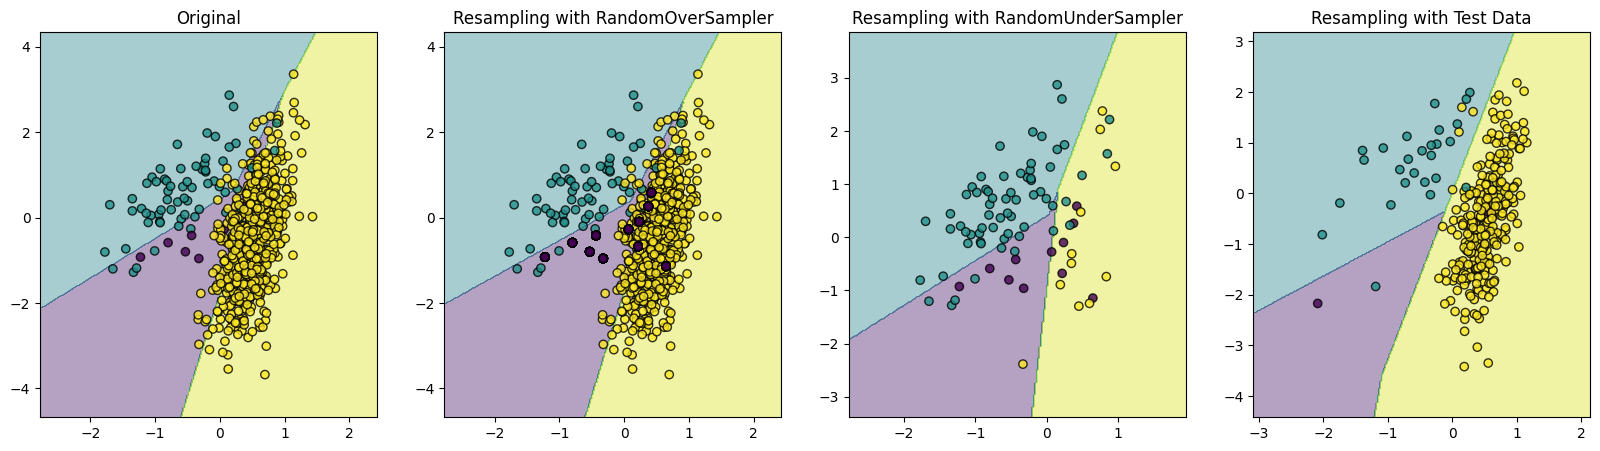

In [51]:
# visualize decision boundaries
fig, axs = plt.subplots(ncols=4, figsize=(20, 5))
plot_decision_function(X_train, y_train, axs[0])
plot_decision_function(X_train_over, y_train_over, axs[1], "RandomOverSampler")
plot_decision_function(X_train_under, y_train_under, axs[2], "RandomUnderSampler")
plot_decision_function(X_test, y_test, axs[3], "Test Data")

plt.show()